In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

import collections

from absl import app

import nest_asyncio
nest_asyncio.apply()

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from keras.backend import print_tensor

#import gower

import sys
sys.path.append("/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg")
sys.path.append("/home/tester/Desktop/TF/gower/gower")
#print(sys.path)
import simple_fedavg_tff
import gower_dist as gd


2022-07-01 11:11:58.551110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 11:11:58.551146: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


['/home/tester/Desktop/TF/TFF', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/tester/venv/lib/python3.9/site-packages', '/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg', '/home/tester/Desktop/TF/gower/gower', '/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg']


In [2]:
# Training hyperparameters
RUN_NAME = 'F2'
TOTAL_ROUNDS = 600 #NUMBER OF TOTAL TRAINING ROUNDS
ROUNDS_PER_EVAL = 1 #HOW OFTEN TO EVALUATE
TRAIN_CLIENTS_PER_ROUND = 4 #HOW MANY CLIENTS TO SAMPLE PER ROUND
CLIENT_EPOCHS_PER_ROUND = 2 #NUMBER OF EPOCHS IN THE CLIENT TO TAKE PER ROUND
BATCH_SIZE = 32 #BATCH SIZE USED ON THE CLIENT
TEST_BATCH_SIZE = 16 #MINIBATCH SIZE OF TEST DATA
SERVER_LEARNING_RATE = 0.0001 #SERVER LEARNING RATE
CLIENT_LEARNING_RATE = 0.00001 #CLIENT LEARNING RATE
NUM_CLIENTS = 20

TRAIN_SIZE = 40000
TEST_SIZE = 4000

BALANCE_DATA = True
PRINT_SCR = True

In [3]:
#Save cofiguration
CONFIG_STR = 'TOTAL_ROUNDS: ' + str(TOTAL_ROUNDS) + '\nROUNDS_PER_EVAL: ' + str(ROUNDS_PER_EVAL) + '\nTRAIN_CLIENTS_PER_ROUND: ' + str(TRAIN_CLIENTS_PER_ROUND) + '\nCLIENT_EPOCHS_PER_ROUND: ' + str(CLIENT_EPOCHS_PER_ROUND) + '\nBATCH_SIZE: ' + str(BATCH_SIZE) + '\nTEST_BATCH_SIZE: ' + str(TEST_BATCH_SIZE) + '\nSERVER_LEARNING_RATE: ' + str(SERVER_LEARNING_RATE) + '\nCLIENT_LEARNING_RATE: '+ str(CLIENT_LEARNING_RATE) + '\nNUM_CLIENTS: ' + str(NUM_CLIENTS) + '\nTRAIN_SIZE: ' + str(TRAIN_SIZE) + '\nTEST_SIZE: ' + str(TEST_SIZE) + '\nBALANCE_DATA: ' + str(BALANCE_DATA) + '\n'
with open('./experiments/' + RUN_NAME + 'conf.txt', 'w') as f: #Should be XML?
    f.write(CONFIG_STR)

In [4]:
df = pd.read_csv("../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_Network_dataset/Train_Test_Network.csv")
df.pop('type')
df.pop('ts')
df.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label
0,3.122.49.24,1883,192.168.1.152,52976,tcp,-,80549.530260,1762852,41933215,OTH,...,0,0,0,-,-,-,bad_TCP_checksum,-,F,0
1,192.168.1.79,47260,192.168.1.255,15600,udp,-,0.000000,0,0,S0,...,0,0,0,-,-,-,-,-,-,0
2,192.168.1.152,1880,192.168.1.152,51782,tcp,-,0.000000,0,0,OTH,...,0,0,0,-,-,-,bad_TCP_checksum,-,F,0
3,192.168.1.152,34296,192.168.1.152,10502,tcp,-,0.000000,0,0,OTH,...,0,0,0,-,-,-,-,-,-,0
4,192.168.1.152,46608,192.168.1.190,53,udp,dns,0.000549,0,298,SHR,...,0,0,0,-,-,-,bad_UDP_checksum,-,F,0


In [5]:
cat_indexs = [0, 1, 2, 3, 4, 5, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41]
num_indexs = [6, 7, 8, 10, 11, 12, 13, 14, 33, 34]
#bool_indexs = []


In [6]:
# Which cols are categorical
cat_index_bool = [False] * 42
for e in cat_indexs:
    cat_index_bool[e] = True

In [7]:
# # Percentage malware
perc = len(df.loc[df['label']==1])/len(df)
if PRINT_SCR:
    print(perc)

# Balance dataset
if(BALANCE_DATA):
    num_anom = len(df.loc[df['label']==1])
    df_anom = df.loc[df['label']==1]
    df_balance = df.loc[df['label']==0]
    df_balance = df_balance.sample(num_anom, replace=False)
    df_concated = pd.concat([df_balance, df_anom])
    balanced_data = df_concated
    df = balanced_data


0.34930147513355586


In [8]:
data = df.sample(TRAIN_SIZE + TEST_SIZE, random_state=16)

train_data = data.head(TRAIN_SIZE)
train_labels = train_data.pop('label')
test_data = data.tail(TEST_SIZE)
test_labels = test_data.pop('label')

labels = data.pop('label')


In [9]:

#IID or NOIID? SPLIT DATA AMONG CLIENTS
client_id_train = np.random.choice(range(NUM_CLIENTS), size=TRAIN_SIZE, replace=True)
client_id_test = np.random.choice(range(NUM_CLIENTS), size=TEST_SIZE, replace=True)


In [10]:
#Determine max_client_ds_size and min_client_ds_size
max_client_ds_size = -1
min_client_ds_size = len(train_data.loc[client_id_train == 0])
for id in range(0,NUM_CLIENTS):
    tmp_len = len(train_data.loc[client_id_train == id])
    if(tmp_len > max_client_ds_size):
        max_client_ds_size = tmp_len
    if(tmp_len < min_client_ds_size):
        min_client_ds_size = tmp_len

In [11]:
#TRAIN: Create a dict where keys are client ids format for tff.simulation.datasets.TestClientData
# Create distance matrix with each client data min_client_ds_size rows

train_cl_dict = {}
for id in range(0,NUM_CLIENTS):
    tmp_train_df = pd.DataFrame()
    
    tmp_features = train_data.loc[client_id_train == id]
    tmp_labels = train_labels.loc[client_id_train == id]

    tmp_gower_mat = gd.gower_matrix_limit_cols(tmp_features,min_client_ds_size,cat_features=cat_index_bool)
    
    for i in range(0,min_client_ds_size):
        tmp_train_df[str(i)] = tmp_gower_mat[:,i]
    
    tmp_train_df['label'] = tmp_labels.values

    tmp_train_dict = {name: np.array(value) 
                         for name, value in tmp_train_df.items()}
    
    train_cl_dict[str(id)]=tmp_train_dict.copy()
    

In [12]:
#TEST SPLITED

test_cl_dict = {}
for id in range(0,NUM_CLIENTS):
    tmp_test_df = pd.DataFrame()
    
    train_instances = train_data.loc[client_id_train == id]
    test_instances = test_data.loc[client_id_test == id]

    tmp_features = pd.concat([train_instances, test_instances])
    
    tmp_labels = test_labels.loc[client_id_test == id]

    tmp_gower_mat = gd.gower_matrix_limit_cols(tmp_features,min_client_ds_size,cat_features=cat_index_bool)
    
    for i in range(0,min_client_ds_size):
        tmp_test_df[str(i)] = tmp_gower_mat[len(train_instances):,i]
    
    tmp_test_df['label'] = tmp_labels.values

    tmp_test_dict = {name: np.array(value) 
                         for name, value in tmp_test_df.items()}
    test_cl_dict[str(id)]=tmp_test_dict.copy()

In [13]:
#CONVERT TO TFF DATASET
#netw_ds = tf.data.Dataset.from_tensor_slices((netw_features_dict, netw_labels))
#netw_ds = tf.data.Dataset.from_tensor_slices(netw_features_dict)
train_fd_ds = tff.simulation.datasets.TestClientData(train_cl_dict)
test_fd_ds = tff.simulation.datasets.TestClientData(test_cl_dict)




2022-07-01 11:19:25.268611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-01 11:19:25.268660: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-01 11:19:25.268680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2022-07-01 11:19:25.268962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test FedAVG

In [14]:
def evaluate(keras_model, test_dataset):
  """Evaluate the acurracy of a keras model on a test dataset."""
  #metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  metric = tf.keras.metrics.SparseCategoricalCrossentropy()
  for batch in test_dataset:
    predictions = keras_model(batch['x'])
    metric.update_state(y_true=batch['y'], y_pred=predictions)
  return metric.result()

def get_custom_dataset():
  def element_fn(element):
    tmp_features = []
    for i in range(0,min_client_ds_size):
      tmp_features.append(element[str(i)])
    features = tf.convert_to_tensor(tmp_features, dtype=tf.float32)
    
    return collections.OrderedDict(
      # tf.expand_dims? ADD MORE COLUMNS
        x=features, y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    return dataset.map(element_fn).shuffle(buffer_size=max_client_ds_size).repeat(
        count=CLIENT_EPOCHS_PER_ROUND).batch(
            BATCH_SIZE, drop_remainder=False)
   
  
  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(
        TEST_BATCH_SIZE, drop_remainder=False)
  
  netw_train = train_fd_ds.preprocess(preprocess_train_dataset)
  
  netw_test = preprocess_test_dataset(
    test_fd_ds.create_tf_dataset_from_all_clients())
  
  return netw_train, netw_test


def create_fedavg_model(only_digits=True):
  """The CNN model used in https://arxiv.org/abs/1602.05629.

  Args:
    only_digits: If True, uses a final layer with 10 outputs, for use with the
      digits only EMNIST dataset. If False, uses 62 outputs for the larger
      dataset.

  Returns:
    An uncompiled `tf.keras.Model`.
  """
  initializer = tf.keras.initializers.GlorotNormal(seed=5)
  return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(min_client_ds_size,)),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(66, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(69, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(69, activation="relu"),
    #tf.keras.layers.Dense(256, activation="relu"),
    #tf.keras.layers.Dense(256, activation="relu"),
    #tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(11, activation="relu"),
    tf.keras.layers.Dense(85, activation="relu"),
    #tf.keras.layers.Dense(256, activation="relu"),
    #tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(2),
    #tf.keras.layers.Dropout(0.1)
    #tf.keras.layers.Dense(2, activation="relu"),
    #tf.keras.layers.Dense(32, activation="relu"),
    #tf.keras.layers.Dense(4, activation="relu"),
    #tf.keras.layers.Dense(1, activation="sigmoid"),
    tf.keras.layers.Softmax()
    ])


def server_optimizer_fn():
  return tf.keras.optimizers.Adam(learning_rate=SERVER_LEARNING_RATE)


def client_optimizer_fn():
  return tf.keras.optimizers.Adam(learning_rate=CLIENT_LEARNING_RATE)

In [15]:
#WITH VALIDATION

# If GPU is provided, TFF will by default use the first GPU like TF. The
# following lines will configure TFF to use multi-GPUs and distribute client
# computation on the GPUs. Note that we put server computatoin on CPU to avoid
# potential out of memory issue when a large number of clients is sampled per
# round. The client devices below can be an empty list when no GPU could be
# detected by TF.

train_loss_list = []
val_loss_list = []

client_devices = tf.config.list_logical_devices('GPU')
server_device = tf.config.list_logical_devices('CPU')[0]
tff.backends.native.set_local_python_execution_context(
    server_tf_device=server_device, client_tf_devices=client_devices)
train_data, valid_data = get_custom_dataset()
def tff_model_fn():
  """Constructs a fully initialized model for use in federated averaging."""
  keras_model = create_fedavg_model(only_digits=True)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
  return tff.learning.from_keras_model(
      keras_model,
      loss=loss,
      metrics=metrics,
      input_spec=train_data.element_type_structure)

iterative_process = simple_fedavg_tff.build_federated_averaging_process(
    tff_model_fn, server_optimizer_fn, client_optimizer_fn)
server_state = iterative_process.initialize()
# Keras model that represents the global model we'll evaluate test data on.
keras_model = create_fedavg_model(only_digits=True)
for round_num in range(TOTAL_ROUNDS):
    sampled_clients = np.random.choice(
        train_data.client_ids,
        size=TRAIN_CLIENTS_PER_ROUND,
        replace=False)
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients
    ]
    server_state, train_metrics = iterative_process.next(
        server_state, sampled_train_data)
    if (PRINT_SCR):  
      print(f'Round {round_num}')
      print(f'\tTraining metrics: {train_metrics}')
    train_loss_list.append(train_metrics.get('loss'))   
    if round_num % ROUNDS_PER_EVAL == 0:
      server_state.model.assign_weights_to(keras_model)
      val_loss = evaluate(keras_model, valid_data)
      val_loss_list.append(val_loss)
      if PRINT_SCR:
          print(f'\tValidation loss: {val_loss: .7f}')

Round 0
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.5600372), ('loss', 0.6870988), ('num_examples', 16140), ('num_batches', 506)])
	Validation loss:  0.6955254
Round 1
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.5753057), ('loss', 0.68578464), ('num_examples', 16028), ('num_batches', 503)])
	Validation loss:  0.6940363
Round 2
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.59768635), ('loss', 0.6854875), ('num_examples', 16338), ('num_batches', 513)])
	Validation loss:  0.6923825
Round 3
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.6191503), ('loss', 0.6865191), ('num_examples', 15770), ('num_batches', 494)])
	Validation loss:  0.6911713
Round 4
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.6280128), ('loss', 0.6843006), ('num_examples', 16264), ('num_batches', 511)])
	Validation loss:  0.6903927
Round 5
	Training metrics: OrderedDict([('sparse_categorical_accuracy', 0.64994305), ('l

: 

: 

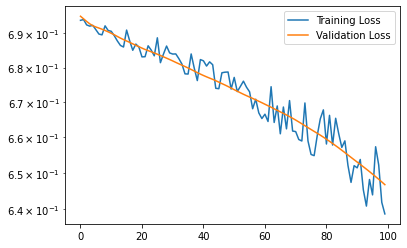

In [ ]:
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.yscale('log')
plt.legend()

In [ ]:
def predict(model, data):
  reconstructions = model(data)
  return reconstructions

def get_accuracy_list(dict):
  acc_list = []
  for i in range(0,NUM_CLIENTS):
    df_cl = pd.DataFrame.from_dict(dict[str(i)]).copy()
    tmp_labels = df_cl.pop('label')
    preds = predict(keras_model, np.array(df_cl))
    acc_list.append(accuracy_score(tmp_labels.astype(int), np.round(preds[:,1], decimals=0)))
  return acc_list
    

def save_stats(predictions, labels, print_scr=True):

  acc = "{:.4f}".format(accuracy_score(labels, predictions))
  prec = "{:.4f}".format(precision_score(labels, predictions, zero_division=0))
  rcl = "{:.4f}".format(recall_score(labels, predictions, zero_division=0))
  f1 = "{:.4f}".format(f1_score(labels, predictions, zero_division=0))
  roc = "{:.4f}".format(roc_auc_score(labels, predictions))

  if print_scr:
    print("Accuracy = " + acc)
    print("Precision = " + prec)
    print("Recall = " + rcl) #sensitivity
    print("F1 = " + f1)
    print("ROC_AUC = " + roc)

  return (acc + " " + prec + " " + rcl + " " + f1 + " " + roc)


In [ ]:
test = pd.DataFrame.from_dict(test_cl_dict[str(np.random.randint(0,NUM_CLIENTS-1))]).copy()
labs = test.pop('label')
preds = predict(keras_model, np.array(test))
a = save_stats(np.round(preds[:,1], decimals=0), labs.astype(int), PRINT_SCR)

Accuracy = 0.5556
Precision = 0.5833
Recall = 0.7000
F1 = 0.6364
ROC_AUC = 0.5375


In [ ]:
# Save result in txt
with open('./experiments/' + RUN_NAME + '.txt', 'w') as f:
    f.write('CL_ID TRAIN_DS_SIZE ACC PREC RCL F1 ROC \n')

for i in range(0, NUM_CLIENTS):
    test = pd.DataFrame.from_dict(test_cl_dict[str(i)]).copy()
    labs = test.pop('label')
    preds = predict(keras_model, np.array(test))
    results = save_stats(np.round(preds[:,1], decimals=0), labs.astype(int), False)
    out = str(i) + ' ' + str(len(client_id_train[client_id_train==i])) + ' ' + results
    with open('./experiments/'+ RUN_NAME + '.txt', 'a') as f:
        f.write(out + " \n")

In [ ]:
# save model
keras_model.save('./experiments/' + RUN_NAME + '.h5')
#model = tf.keras.models.load_model("./experiments/e3.h5")

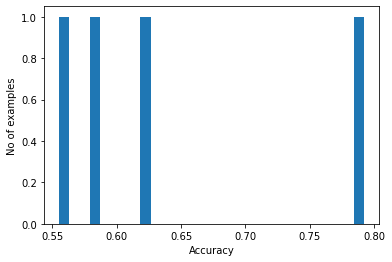

In [ ]:
#Print accuracies

acc_list = get_accuracy_list(test_cl_dict)

plt.hist(acc_list, bins=30)
plt.xlabel("Accuracy")
plt.ylabel("No of examples")
plt.show()